**Cinematic Trends Analyzer: 120 Years of Movie History**


In [51]:
#Import
import json
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams.update({'figure.dpi': 120})

DATA_DIR = Path('../data')
DATA_DIR.mkdir(exist_ok=True,parents=True)

OUT_DIR = Path('../output')
OUT_DIR.mkdir(exist_ok=True,parents=True)

In [52]:
#Functions

def download_json_files(dase_url:str, decades: np.array, out_folder: Path) -> int:
  total = 0

  for i in decades:
    file_path = f"{dase_url}movies-{i}s.json"
    file_name = out_folder / f"movies-{i}s.json"
    try:
      response = requests.get(file_path,timeout=20)
      response.raise_for_status()
      data = response.json()
      total += len(data)

      with open(file_name,'w',encoding='UTF-8') as file:
        json.dump(data,file,indent=4,ensure_ascii=False)
      print(f"Saved {file_name} ({len(data)} records)")

    except Exception as e:
      print(f"Failed to fetch {file_path}: {e}")
  return total

def load_and_clean_json_files(decades:np.array, folder: Path) -> pd.DataFrame:
    full_data=[]

    for i in decades:
      path = folder / f'movies-{i}s.json'
      if not path.exists():
        continue
      with open(path,'r',encoding='UTF-8') as file:
        data = json.load(file)
        for d in data:
          for key in ['href', 'extract', 'thumbnail', 'thumbnail_width', 'thumbnail_height']:
            d.pop(key,None)
            if not d.get('title') or not d.get('year'):
              continue
            full_data.append(d)
    df = pd.DataFrame(full_data)

    df['genres'] = df['genres'].apply(lambda x: x if isinstance(x, list) else ([] if pd.isna(x) else [x]))
    df['cast'] = df['cast'].apply(lambda x: x if isinstance(x, list) else ([] if pd.isna(x) else [x]))

    df['year'] = pd.to_numeric(df['year'],errors = 'coerce').astype('Int64')
    df = df.dropna(subset=['year'])
    df['year']=df['year'].astype(int)
    return df

def save_dataframe(df: pd.DataFrame, path:Path):
  df.to_csv(path, index = False)
  print(f'Saved dataframe to {path} (rows: {len(df)})')


In [53]:
#Data loading
dase_url = "https://raw.githubusercontent.com/prust/wikipedia-movie-data/refs/heads/master/"
decades=np.arange(1900,2020,10)

print(f"1) Loading JSON-files...")
total_movies = download_json_files(dase_url,decades, Path('.'))
print(f"Total number of movies dowenloaded: {total_movies}")


1) Loading JSON-files...
Saved movies-1900s.json (354 records)
Saved movies-1910s.json (3869 records)
Saved movies-1920s.json (5536 records)
Saved movies-1930s.json (4429 records)
Saved movies-1940s.json (4519 records)
Saved movies-1950s.json (3151 records)
Saved movies-1960s.json (1582 records)
Saved movies-1970s.json (1617 records)
Saved movies-1980s.json (2272 records)
Saved movies-1990s.json (2849 records)
Saved movies-2000s.json (2430 records)
Saved movies-2010s.json (2512 records)
Total number of movies dowenloaded: 35120


In [54]:
#Loading and cleaning data
print(f"\n2) Reading and cleaning files...")
df = load_and_clean_json_files(decades, Path('.'))

print("\n DataFrame shape:", df.shape)
print(df.info())


2) Reading and cleaning files...

 DataFrame shape: (175600, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175600 entries, 0 to 175599
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   175600 non-null  object
 1   year    175600 non-null  int64 
 2   cast    175600 non-null  object
 3   genres  175600 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.4+ MB
None


In [55]:
#DownLoad cleaned dataset

clean_path = DATA_DIR / 'movies_clean.csv'
save_dataframe(df,clean_path)

Saved dataframe to ../data/movies_clean.csv (rows: 175600)



Top-10 genres:
      genres  number of films
9      Drama            12831
4     Comedy             9693
29    Silent             6825
40   Western             4153
25   Romance             2659
5      Crime             2464
0     Action             2027
38  Thriller             1760
20   Musical             1678
39       War             1649


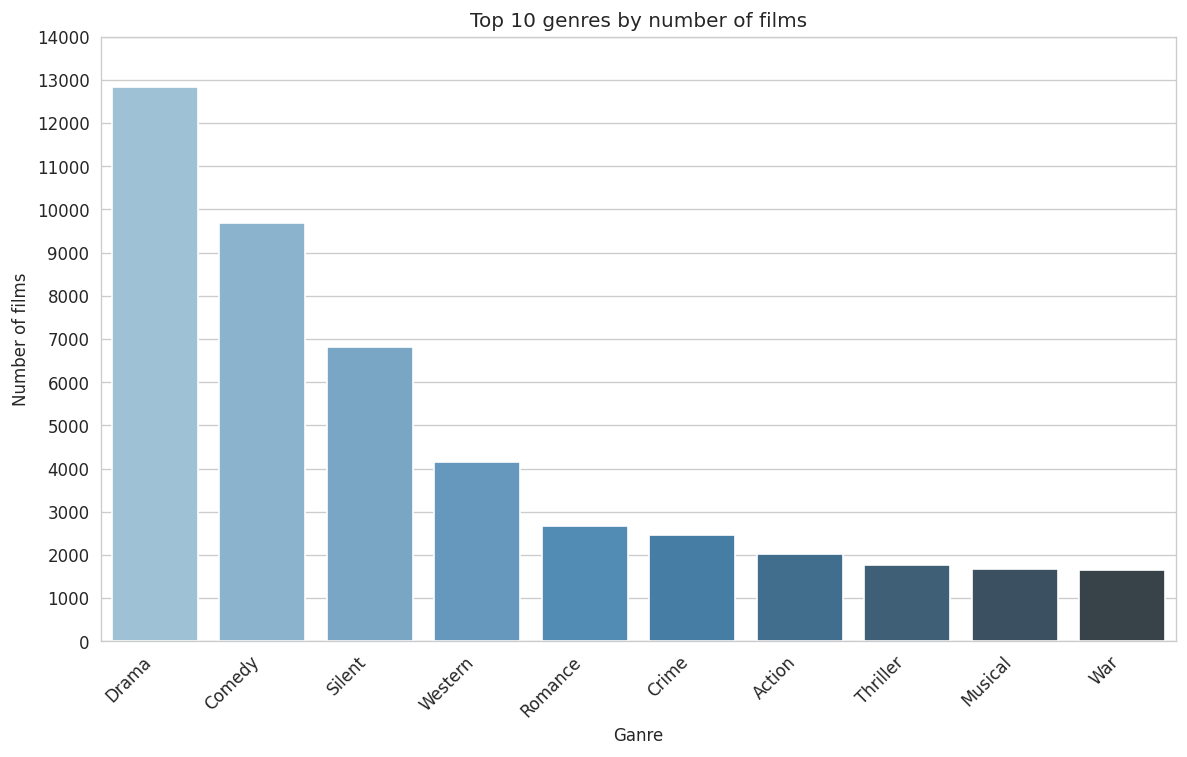

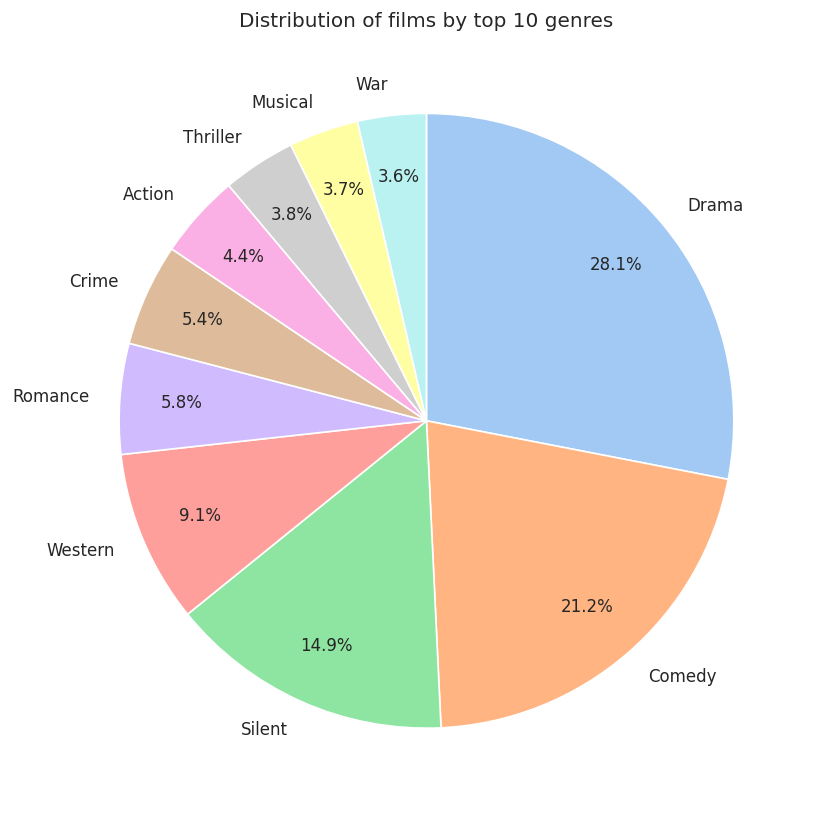

In [56]:
#Genres analysis
# Expand genres into separate rows for aggregations
df_genres = df.explode('genres')
df_genres = df_genres[df_genres['genres'].notna()]

#Top-10 genres
group_by_genres = (
                  df_genres.groupby('genres',as_index=False)['title']
                  .nunique()
                  .rename(columns={'title':"number of films"})
                  .sort_values('number of films',ascending=False)
                  .head(10)
)
print('\nTop-10 genres:')
print(group_by_genres)

#Vizualisation
#Bar chart - Top 10 genres
fig,ax=plt.subplots(figsize=(10,6))

sns.barplot( x='genres', y='number of films', data=group_by_genres, palette = 'Blues_d')
plt.title('Top 10 genres by number of films')
plt.xlabel("Ganre")
plt.ylabel("Number of films")
plt.yticks(range(0,15000,1000))
plt.tight_layout()
plt.xticks(rotation = 45, ha = 'right')
plt.savefig(OUT_DIR / 'top10_genres_bar.png')
plt.show()


#Pie chart (top 10)
fig,ax=plt.subplots(figsize=(7,7))

plt.pie(x='number of films',
        labels='genres',
        data=group_by_genres,
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.8,
        colors=sns.color_palette("pastel"),
        counterclock=False)
plt.title("Distribution of films by top 10 genres")
plt.tight_layout()
plt.savefig(OUT_DIR / 'top10_genres_pie.png')
plt.show()

**Top 10 genres**

The most popular genre is Drama (12,831 films), followed by Comedy (9,693) and Silent (6,825).

This indicates that during the period under review, viewers mainly chose drama and comedy films, and that silent films accounted for a significant share.

Genres such as Western, Romance, and Crime were also quite popular, but lagged behind the leaders in terms of the number of films.

Summary table: Top-10 actors by number of films
                   actor  number of movies
10044       Harold Lloyd               950
10502        Hoot Gibson               785
4281    Charles Starrett               685
13331         John Wayne               675
11040          Jack Holt               640
13380  Johnny Mack Brown               615
3532          Buck Jones               615
2336        Bebe Daniels               565
26626       William Boyd               525
21370     Raymond Hatton               525


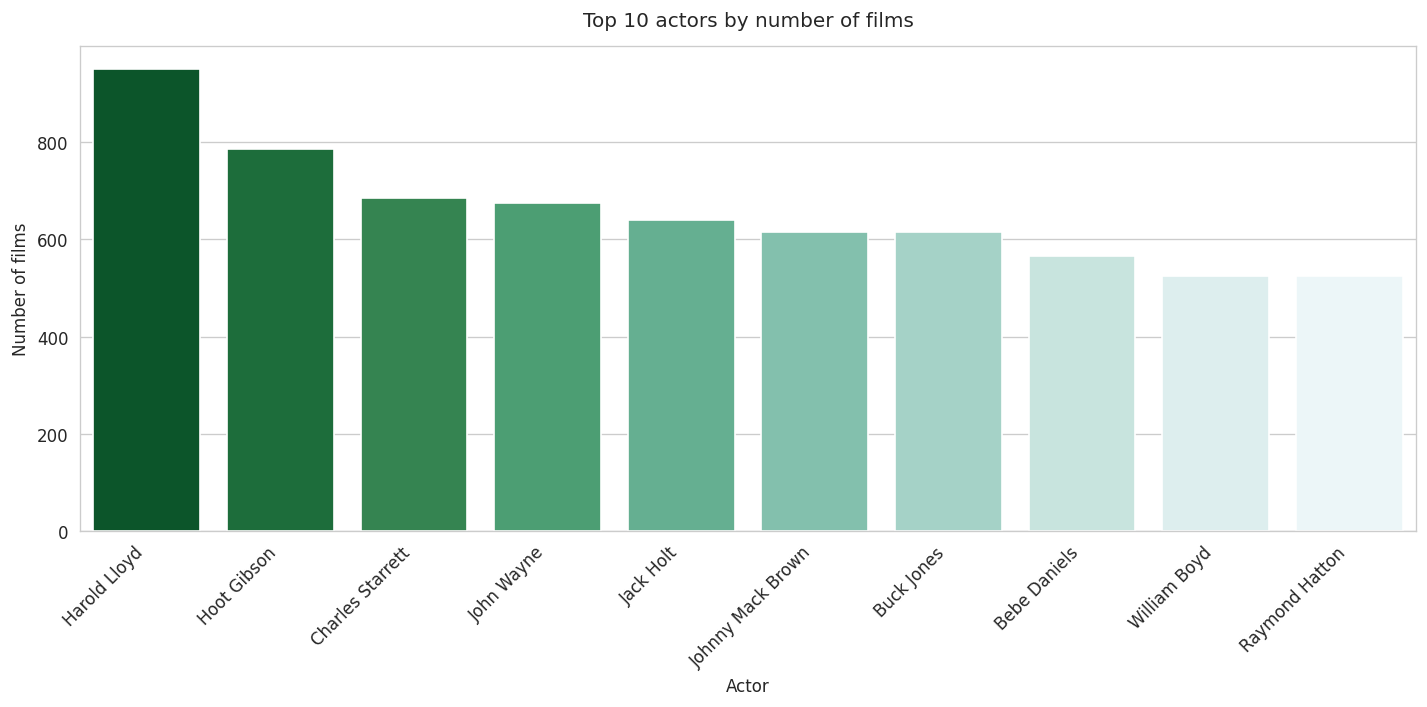

In [57]:
#Actors analysis
df_cast=df.explode('cast')
df_cast = df_cast[df_cast['cast'].notna()]

group_by_actors = (df_cast.groupby('cast',as_index=False)['title']
                  .count()
                  .rename(columns={'title':'number of movies','cast':'actor'})
                  .sort_values('number of movies',ascending=False)
                  .head(10)
)
print('Summary table: Top-10 actors by number of films')
print(group_by_actors)

#Bar chart TOP-10 actors
plt.figure(figsize=(12,6))

sns.barplot(x='actor',y='number of movies',data=group_by_actors,palette="BuGn_r")
plt.title('Top 10 actors by number of films',pad=12)
plt.xlabel('Actor')
plt.ylabel('Number of films')
plt.xticks(rotation=45, ha = 'right')
plt.tight_layout()
plt.savefig(OUT_DIR / 'top10_actors_bar.png')

plt.show()

**Top 10 actors by number of films**

The most prolific actors were Harold Lloyd (950 films), Hoot Gibson (785), and Charles Starrett (685).

All of these actors were active during the silent and early sound film eras, as evidenced by their large number of roles.

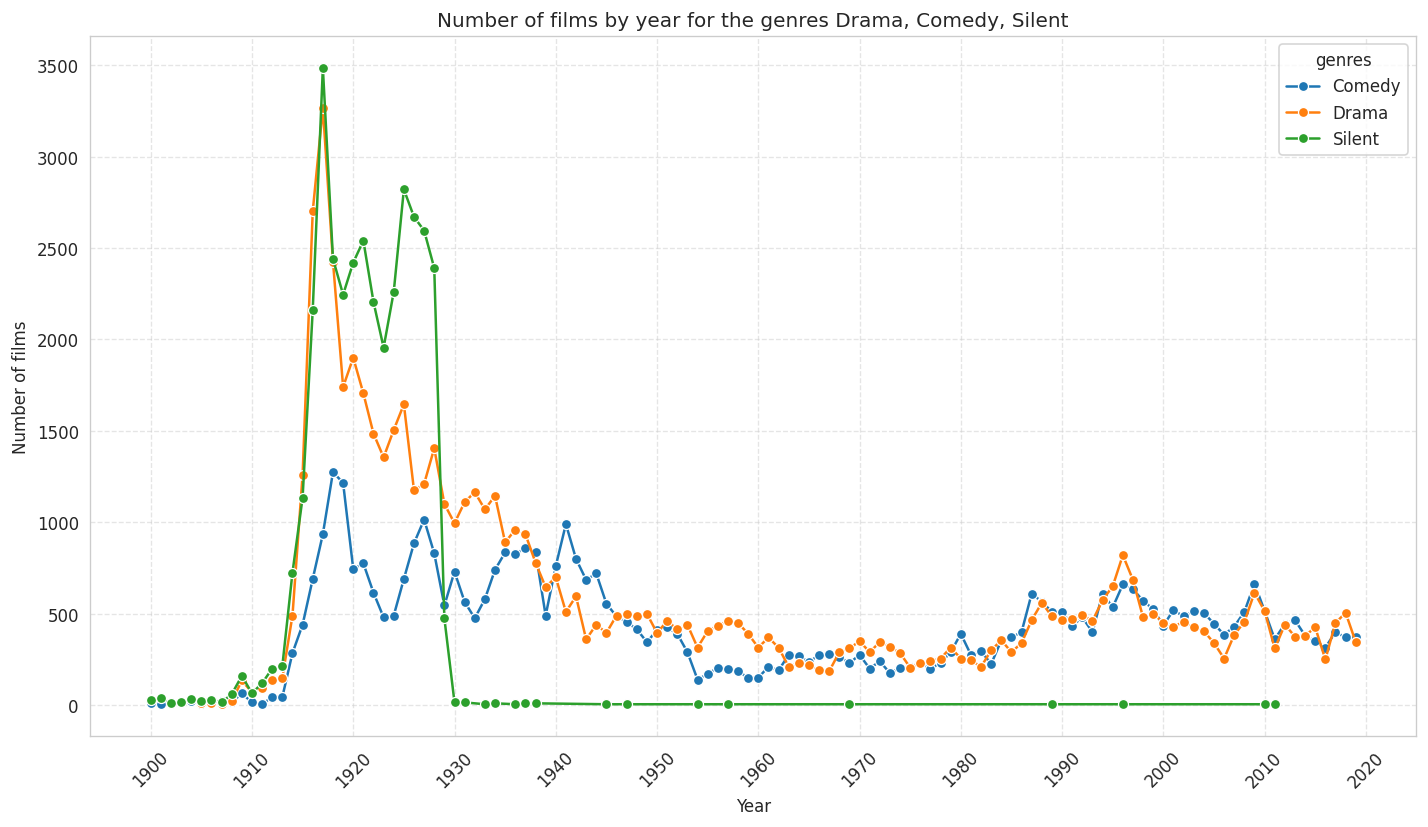

In [58]:
#Analysis of genre trends by year
# Aggregate by (genre, year)
group_by_year_and_genre = (df_genres.groupby(['genres','year'],as_index=False)['title']
                           .count()
                           .rename(columns={'title': "count"})
)

select_ganres = ["Drama","Comedy","Silent"]

group_by_year_and_genre = group_by_year_and_genre[group_by_year_and_genre['genres'].isin(select_ganres)]

#Lineplot
plt.figure(figsize=(12,7))

sns.lineplot(data=group_by_year_and_genre,x='year',y='count',hue='genres',marker = 'o')
plt.title('Number of films by year for the genres Drama, Comedy, Silent')
plt.xlabel('Year')
plt.ylabel('Number of films')
plt.xticks(range(1900,2030,10), rotation = 45)
plt.grid(True,linestyle='--',alpha = 0.5)
plt.tight_layout()
plt.savefig(OUT_DIR / 'genre_trends_selected.png')
plt.show()

**Analysis of Genre Trends (Drama, Comedy, Silent) Over Time**

The chart clearly illustrates a historical transition in film production from silent films to sound-based Drama and Comedy.

While technological innovation drastically reduced silent films, popular genres like Drama and Comedy continued to evolve, highlighting both industry adaptation and changing audience preferences.

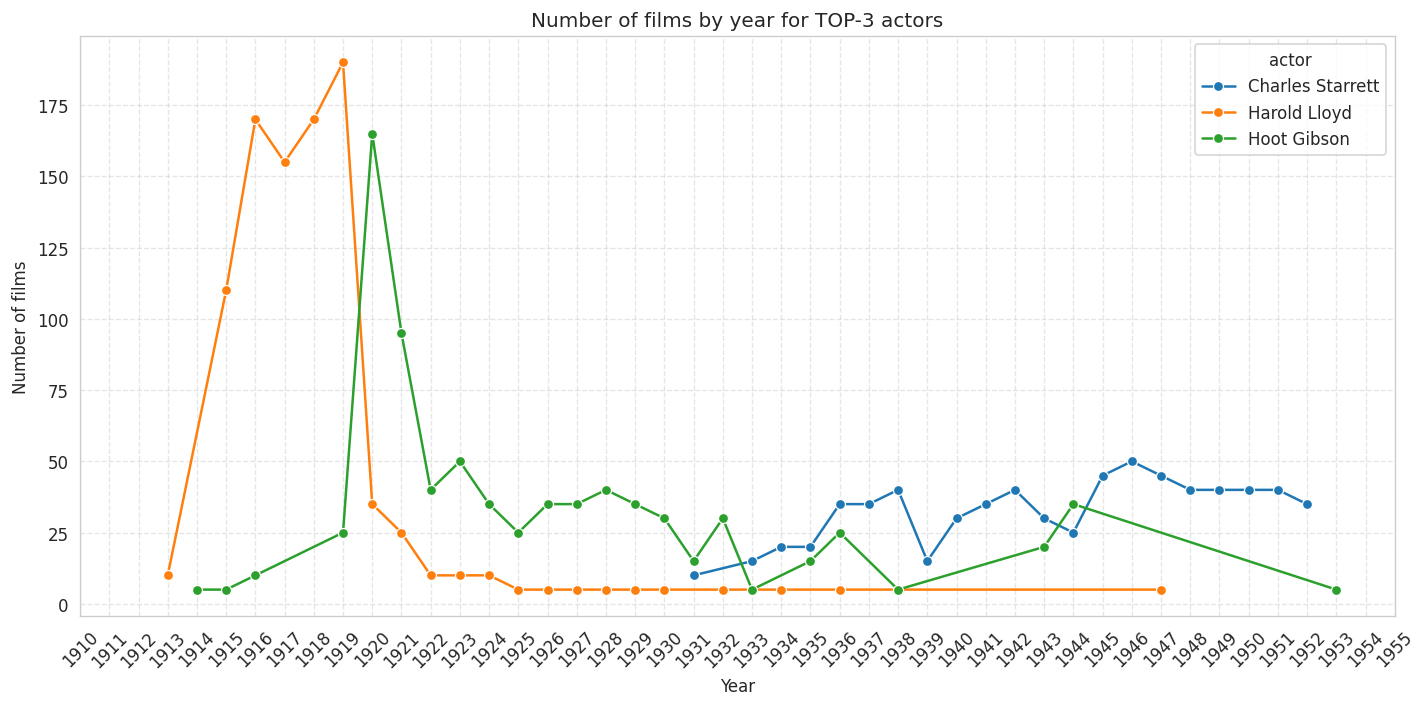

In [59]:
#Analysis of actor trends by year (TOP-3)
top2_actors = group_by_actors['actor'].head(3).tolist()

group_by_actors_year = (df_cast.groupby(['cast','year'],as_index=False)['title']
                        .count()
                        .rename(columns = {'cast': 'actor', 'title': 'count'})
)

group_by_actors_year = group_by_actors_year[group_by_actors_year['actor'].isin(top2_actors)]

#Lineplot
fig,ax=plt.subplots(figsize=(12,6))

sns.lineplot(data=group_by_actors_year,x='year',y='count',hue='actor',marker = 'o')
plt.title("Number of films by year for TOP-3 actors")
plt.xlabel("Year")
plt.ylabel("Number of films")
plt.xticks(range(1910,1956,1),rotation=45)
plt.grid(True,linestyle='--',alpha=0.5)
plt.tight_layout()
plt.savefig(OUT_DIR / 'actors_trends_top3.png')
plt.show()

**Number of films by year for TOP-3 actors**

The three most popular actors had different periods of activity.

* Harold Lloyd was actively filming in the 1910s, but by 1920 his activity had
declined sharply.
* Hoot Gibson was active mainly in the 1920s and 1930s, peaking in 1919–1920.
* Charles Starrett appeared later, in the 1930s, and remained active until the early 1950s.

This shows that each actor dominated a different historical period of cinema.


Top-10 actors: top3 vs other (summary):
               actor  number in top3  number in other  total_movies  % of top3
0       Bebe Daniels             112                1           565      19.82
1         Buck Jones              50               71           615       8.13
2   Charles Starrett               7              129           685       1.02
3       Harold Lloyd             189                0           950      19.89
4        Hoot Gibson             114               43           785      14.52
5          Jack Holt              97               30           640      15.16
6         John Wayne              44               91           675       6.52
7  Johnny Mack Brown              15              108           615       2.44
8     Raymond Hatton              44               61           525       8.38
9       William Boyd              31               74           525       5.90


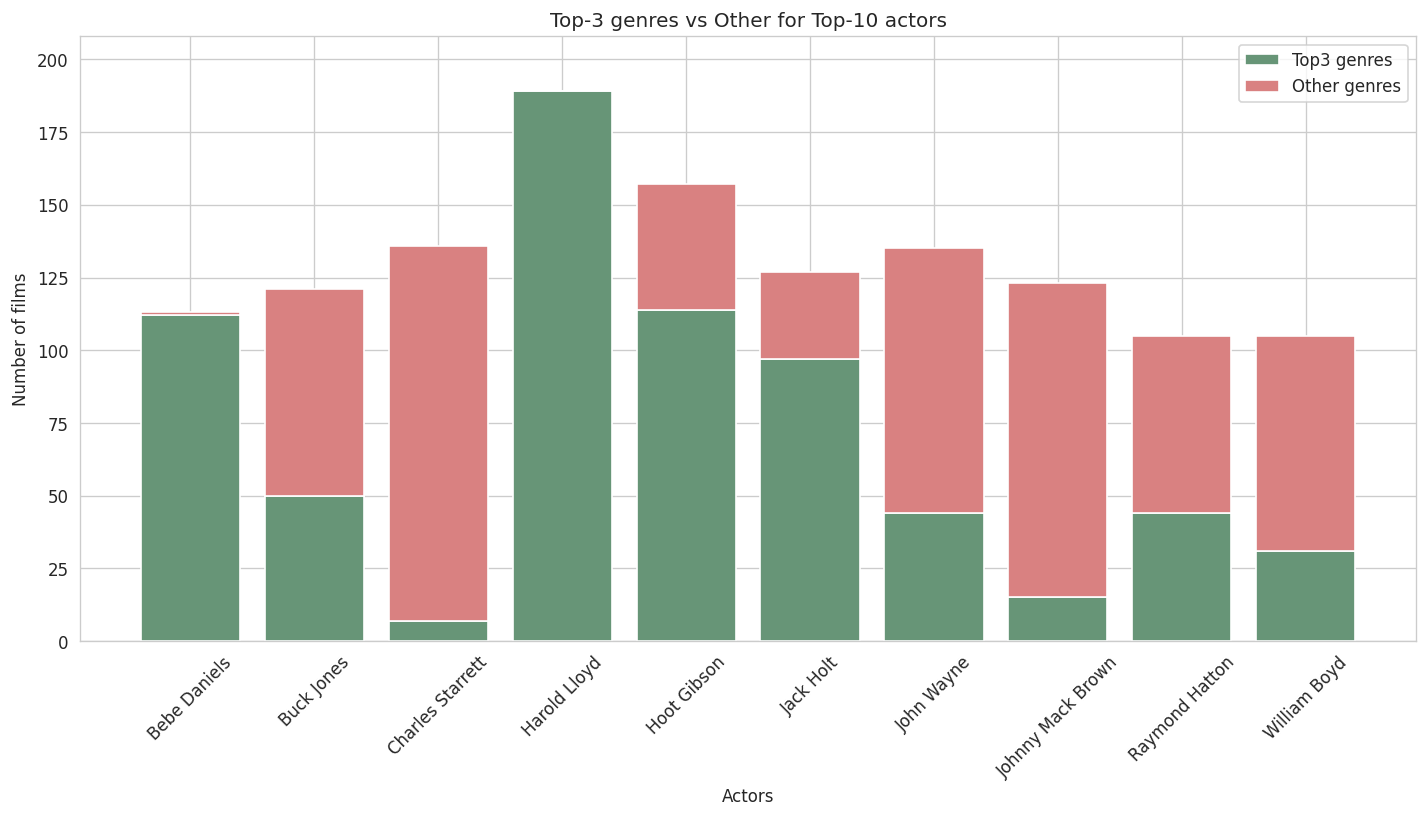

In [60]:
#Top 3 genres vs other genres for top 10 actors
top3_genres = group_by_genres['genres'].head(3).tolist()
top10_actors = group_by_actors['actor'].head(10).tolist()


df['has_top3']=df['genres'].apply(lambda g:any(genre in top3_genres for genre in g))

df_exploded_cast = df.explode('cast')

group_top3 = (df_exploded_cast[df_exploded_cast['has_top3']]
              .groupby('cast',as_index=False)['title']
              .nunique()
              .rename(columns={'title':"number in top3", 'cast':'actor'})
)

group_other = (df_exploded_cast[~df_exploded_cast['has_top3']]
               .groupby('cast',as_index=False)['title']
               .nunique()
               .rename(columns={'title':"number in other", 'cast':'actor'})
)

result = group_top3.merge(group_other,on='actor',how='outer').fillna(0)
result = result[result['actor'].isin(top10_actors)]

actors_movies = group_by_actors.rename(columns={'number of movies':'total_movies'})

result = result.merge(actors_movies[['actor','total_movies']],
                      on = 'actor',
                      how='left')

result[['number in top3', 'number in other']] = result[['number in top3', 'number in other']].astype(int)

result['% of top3'] = (result['number in top3'] / result['total_movies']*100).round(2)

print('\nTop-10 actors: top3 vs other (summary):')
print(result[['actor','number in top3', "number in other",'total_movies','% of top3']])

#Stacked bar chart
plt.figure(figsize=(12,6))
bottom = np.zeros(len(result))
x = np.arange(len(result))
plt.bar(x,result['number in top3'],label='Top3 genres',color='#679577')
plt.bar(x,result['number in other'],bottom=result['number in top3'],label='Other genres',color='#d98181')
plt.legend()
plt.title("Top-3 genres vs Other for Top-10 actors")
plt.xlabel("Actors")
plt.ylabel("Number of films")
plt.tight_layout()
plt.xticks(x, result['actor'], rotation=45)
plt.xticks(rotation=45)
plt.ylim(0, (result['number in top3'] + result['number in other']).max() * 1.1)
plt.savefig(OUT_DIR / 'actors_top3_vs_other_stacked.png')
plt.show()

**Top 10 actors: share of films in the top 3 genres**

Harold Lloyd and Bebe Daniels have the highest share of films in the top 3 genres (~19–20%).

Some actors, such as Charles Starrett and Johnny Mack Brown, appeared mainly in genres that are not in the top 3, so their share of the top 3 is less than 3%.

This indicates the specialization of actors: some focus on popular genres, while others focus on niche genres.

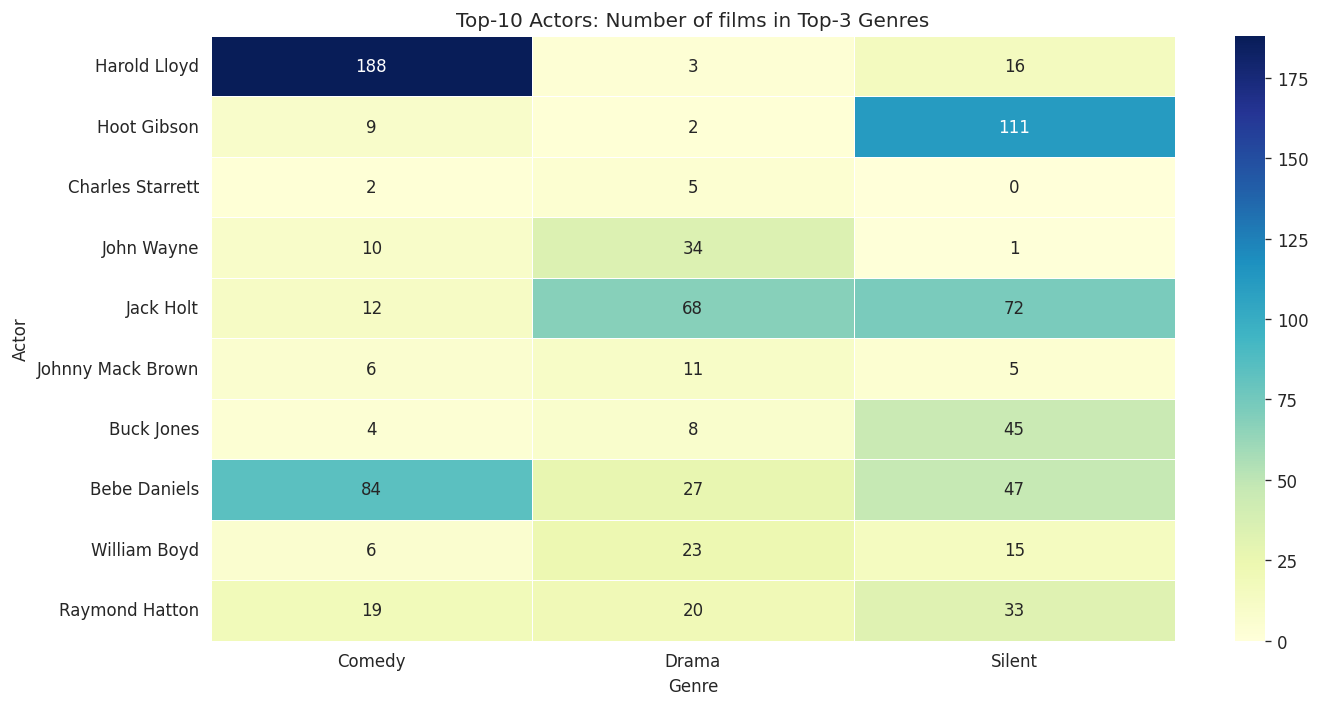

In [61]:
# Pivot table: actors vs genres (number of films)
top3_genres = group_by_genres['genres'].head(3).tolist()
df['has_top3'] = df['genres'].apply(lambda g: [genre for genre in g if genre in top3_genres])
df_exploded_cast = df.explode('cast')

heatmap_data = df_exploded_cast.explode('has_top3').groupby(['cast','has_top3'])['title'].nunique().unstack(fill_value=0)
heatmap_data = heatmap_data.loc[group_by_actors['actor']]  # top 10 actors

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Top-10 Actors: Number of films in Top-3 Genres")
plt.xlabel("Genre")
plt.ylabel("Actor")
plt.tight_layout()
plt.savefig(OUT_DIR / 'pivottable_actors_vs_genres.png')
plt.show()

In [63]:
#Save summary table

group_by_genres.to_csv(OUT_DIR / 'top10_genres.csv', index = False)
group_by_actors.to_csv(OUT_DIR / 'top10_actors.csv', index = False)
result.to_csv(OUT_DIR / 'top10_actors_top3_vs_other.csv', index = False)

print("\nFinished analysis. Outputs (CSV + PNG) in ./output/")



Finished analysis. Outputs (CSV + PNG) in ./output/


**General conclusions**

The popularity of genres and the specialization of actors do not always coincide: great acting careers do not necessarily focus on top genres.

Actors with a high number of films in the top 3 genres, such as Harold Lloyd and Bebe Daniels, had a more “popular” role profile.

Other actors with a large number of films but a low percentage of top 3 genres may have specialized in specific niches (e.g., Western or Crime).